In [1]:
##Importing libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [2]:
#read csv to dataframe
df=pd.read_csv('neighbourhoods.csv')
df.head(10)

Neighbourhood   Latitude  Longitude
0          Bijlmer-Centrum  52.313293   4.954486
1             Bijlmer-Oost  52.320051   4.959330
2            Bos en Lommer  52.378944   4.844829
3   Buitenveldert - Zuidas  52.338396   4.869985
4             Centrum-Oost  52.375488   4.859004
5             Centrum-West  52.375493   4.885268
6   De Aker - Nieuw Sloten  52.346222   4.818332
7   De Baarsjes - Oud-West  52.364294   4.853836
8  De Pijp - Rivierenbuurt  52.354152   4.898587
9    Gaasperdam - Driemond  52.308264   4.990172

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Centrum-West,Amsterdam, Noord Holland'

geolocator = Nominatim(user_agent="amsterdam_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam are 52.3737301, 4.8956908.


In [4]:
# create map of Amsterdam using latitude and longitude values
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

In [5]:
CLIENT_ID = 'C2HUGYJRMOYIKMTJT13SXPB2JXSQABJTEWKFV5ZM3RBF5PCL' 
CLIENT_SECRET = '3HXIAR2ZH1CWT3XQ1FUSUKSKPR0GNEPLEVQEKUAMG4YMH2NU' 
VERSION = '20180605' # Foursquare API version


df.loc[0, 'Neighbourhood']
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
radius= 1000
LIMIT= 100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url
results = requests.get(url).json()


Latitude and longitude values of Bijlmer-Centrum are 52.313293200000004, 4.954486.


In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name          categories        lat       lng
0             Pasta di Mamma  Italian Restaurant  52.314779  4.955087
1                    Kam Yin  Chinese Restaurant  52.315535  4.955318
2  Slagerij-Eetsalon Meester             Butcher  52.313362  4.950450
3            Kwakoe Festival                Park  52.314200  4.961109
4             Coffee Fellows                Café  52.314845  4.953943

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

amsterdam_venues= getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


Bijlmer-Centrum
Bijlmer-Oost
Bos en Lommer
Buitenveldert - Zuidas
Centrum-Oost
Centrum-West
De Aker - Nieuw Sloten
De Baarsjes - Oud-West
De Pijp - Rivierenbuurt
Gaasperdam - Driemond
Geuzenveld - Slotermeer
IJburg - Zeeburgereiland
Noord-Oost
Noord-West
Oostelijk Havengebied - Indische Buurt
Osdorp
Oud-Noord
Oud-Oost
Slotervaart
Watergraafsmeer
Westerpark
Zuid


In [8]:
amsterdam_venues.head()

# create map of Amsterdam using latitude and longitude values
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, category in zip(amsterdam_venues['Venue Latitude'], amsterdam_venues['Venue Longitude'], amsterdam_venues['Venue Category']):
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

(1678, 7)


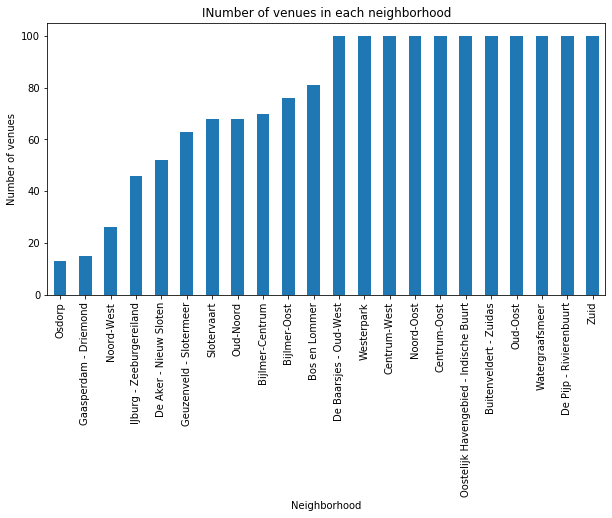

In [9]:
print(amsterdam_venues.shape)
amsterdam_venues.head()
amsterdam_venues.groupby('Neighborhood').count()
categories= amsterdam_venues['Venue Category'].count()

#Barchart to see which neighbourhoods have the highest number of venues

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 

dfcount= amsterdam_venues.groupby('Neighborhood').count()
dfcount=dfcount.sort_values('Venue')
y=dfcount['Venue']

y.plot(kind='bar', figsize=(10, 5))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('INumber of venues in each neighborhood') # add title to the plot

plt.show()

In [10]:
#dataframe for number of venues in each neighbourhood
dfcount.head()
dfcount.reset_index (inplace=True)
dfcount.rename(columns={'Neighborhood':'neighbourhood'}, inplace=True)
dfcount.drop(dfcount.columns[[1,2,4,5,6]], axis=1, inplace=True)
dfcount


neighbourhood  Venue
0                                   Osdorp     13
1                    Gaasperdam - Driemond     15
2                               Noord-West     26
3                 IJburg - Zeeburgereiland     46
4                   De Aker - Nieuw Sloten     52
5                  Geuzenveld - Slotermeer     63
6                              Slotervaart     68
7                                Oud-Noord     68
8                          Bijlmer-Centrum     70
9                             Bijlmer-Oost     76
10                           Bos en Lommer     81
11                  De Baarsjes - Oud-West    100
12                              Westerpark    100
13                            Centrum-West    100
14                              Noord-Oost    100
15                            Centrum-Oost    100
16  Oostelijk Havengebied - Indische Buurt    100
17                  Buitenveldert - Zuidas    100
18                                Oud-Oost    100
19                         Watergraafsmeer    100
20                 De Pijp - Rivierenbuurt    100
21                                    Zuid    100

In [11]:
from folium import plugins
# Opening JSON file 
f = open('neighbourhoods.geojson',) 
  
# returns JSON object as  
# a dictionary 
ams_geo = json.load(f)
ams_cpmap = folium.Map(location=[latitude, longitude], zoom_start=11)
ams_cpmap
#ams_geo

ams_cpmap.choropleth(
    geo_data=ams_geo,
    data=dfcount,
    columns=['neighbourhood','Venue'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venues in Amsterdam'
)

# display map
ams_cpmap

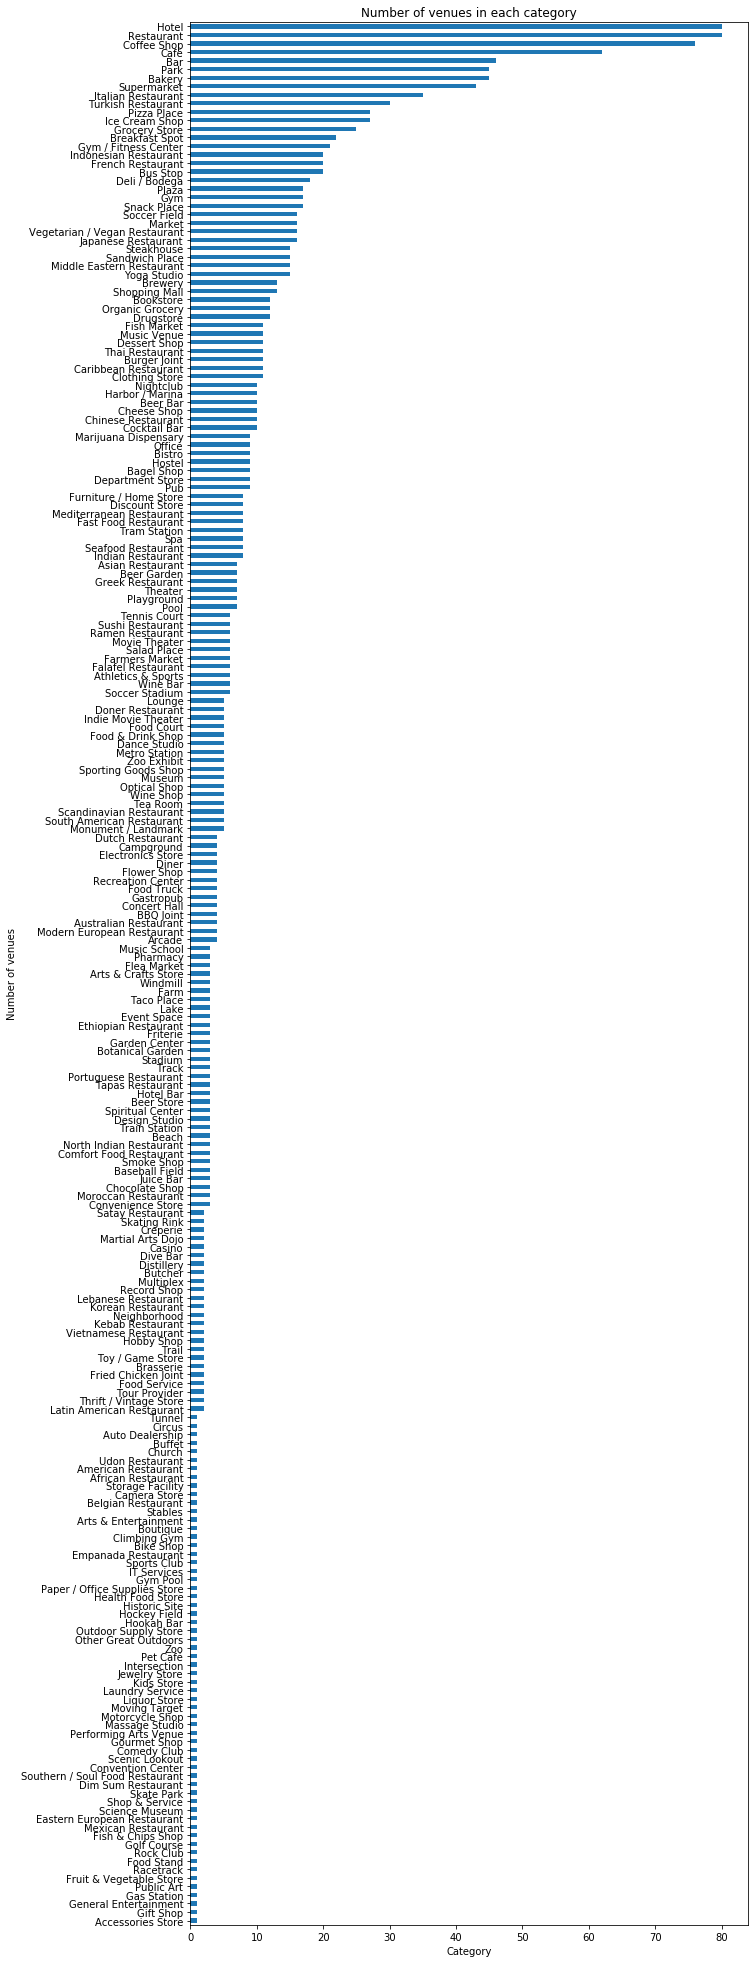

In [12]:
#bar shart for seeing number of venues in each category
dfcat= amsterdam_venues.groupby('Venue Category').count()
dfcat=dfcat.sort_values('Venue')

z=dfcat['Venue']
z.plot(kind='barh', figsize=(10, 35))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of venues in each category') # add title to the plot

plt.show()


In [13]:
amsterdam_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Bijlmer-Centrum              52.313293                4.954486   
1  Bijlmer-Centrum              52.313293                4.954486   
2  Bijlmer-Centrum              52.313293                4.954486   
3  Bijlmer-Centrum              52.313293                4.954486   
4  Bijlmer-Centrum              52.313293                4.954486   

                       Venue  Venue Latitude  Venue Longitude  \
0             Pasta di Mamma       52.314779         4.955087   
1            Kwakoe Festival       52.314200         4.961109   
2                    Kam Yin       52.315535         4.955318   
3  Slagerij-Eetsalon Meester       52.313362         4.950450   
4          Anton de Komplein       52.316640         4.955748   

       Venue Category  
0  Italian Restaurant  
1                Park  
2  Chinese Restaurant  
3             Butcher  
4               Plaza

In [14]:
# one hot encoding
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
amsterdam_onehot['Neighborhood'] = amsterdam_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [amsterdam_onehot.columns[-1]] + list(amsterdam_onehot.columns[:-1])
amsterdam_onehot = amsterdam_onehot[fixed_columns]

amsterdam_onehot.head()

#grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
amsterdam_grouped = amsterdam_onehot.groupby('Neighborhood').mean().reset_index()
amsterdam_grouped

##Clustering of neighborhoods


# set number of clusters
kclusters = 8

amsterdam_grouped_clustering = amsterdam_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:60].astype('int32')



array([5, 5, 4, 4, 0, 4, 1, 0, 4, 2, 1, 7, 0, 6, 0, 3, 1, 4, 1, 4, 4, 4],
      dtype=int32)

In [15]:
#function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = amsterdam_grouped['Neighborhood']

for ind in np.arange(amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0         Bijlmer-Centrum                 Hotel              Bus Stop   
1            Bijlmer-Oost              Bus Stop                  Park   
2           Bos en Lommer                 Hotel            Restaurant   
3  Buitenveldert - Zuidas                 Hotel            Restaurant   
4            Centrum-Oost           Coffee Shop                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Concert Hall        Soccer Stadium          Soccer Field   
1           Supermarket                Bakery        Soccer Stadium   
2                  Café           Coffee Shop           Supermarket   
3                Bakery        Breakfast Spot    Italian Restaurant   
4    Italian Restaurant                   Bar           Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Café                Office           Coffee Shop   
1                Office           Coffee Shop    Chinese Restaurant   
2    Turkish Restaurant                  Park  Fast Food Restaurant   
3   Japanese Restaurant            Steakhouse           Coffee Shop   
4           Yoga Studio         Grocery Store            Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0                Bakery                  Plaza  
1                  Café           Soccer Field  
2        Sandwich Place            Beer Garden  
3                  Café           Tennis Court  
4                 Hotel              Bookstore

In [16]:
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

amsterdam_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
amsterdam_merged =amsterdam_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

amsterdam_merged.tail() # check the last columns!

Neighbourhood   Latitude  Longitude  Cluster Labels  \
17         Oud-Oost  52.360070   4.916510               4   
18      Slotervaart  52.357972   4.805511               1   
19  Watergraafsmeer  52.342437   4.895840               4   
20       Westerpark  52.385631   4.859087               4   
21             Zuid  52.342141   4.848802               4   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
17                 Hotel           Coffee Shop            Restaurant   
18           Supermarket    Turkish Restaurant           Snack Place   
19   Japanese Restaurant           Coffee Shop     Indian Restaurant   
20            Restaurant           Coffee Shop                  Café   
21            Restaurant                Bakery                 Hotel   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
17                   Bar    Italian Restaurant        Breakfast Spot   
18                  Park  Gym / Fitness Center             Drugstore   
19                 Hotel            Restaurant        Breakfast Spot   
20                 Hotel           Pizza Place           Music Venue   
21                  Café    Italian Restaurant           Coffee Shop   

   7th Most Common Venue  8th Most Common Venue  9th Most Common Venue  \
17           Zoo Exhibit            Yoga Studio                 Bakery   
18         Grocery Store                   Café  Indonesian Restaurant   
19                  Café            Pizza Place         Ice Cream Shop   
20    Turkish Restaurant                   Park              Nightclub   
21                   Bar  Indonesian Restaurant         Breakfast Spot   

   10th Most Common Venue  
17      French Restaurant  
18                  Hotel  
19     Italian Restaurant  
20     Italian Restaurant  
21                    Spa

In [17]:

amsterdam_merged['Cluster Labels'].astype(int)
amsterdam_merged.info()
amsterdam_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighbourhood           22 non-null     object 
 1   Latitude                22 non-null     float64
 2   Longitude               22 non-null     float64
 3   Cluster Labels          22 non-null     int32  
 4   1st Most Common Venue   22 non-null     object 
 5   2nd Most Common Venue   22 non-null     object 
 6   3rd Most Common Venue   22 non-null     object 
 7   4th Most Common Venue   22 non-null     object 
 8   5th Most Common Venue   22 non-null     object 
 9   6th Most Common Venue   22 non-null     object 
 10  7th Most Common Venue   22 non-null     object 
 11  8th Most Common Venue   22 non-null     object 
 12  9th Most Common Venue   22 non-null     object 
 13  10th Most Common Venue  22 non-null     object 
dtypes: float64(2), int32(1), object(11)
memory u

Neighbourhood   Latitude  Longitude  Cluster Labels  \
0         Bijlmer-Centrum  52.313293   4.954486               5   
1            Bijlmer-Oost  52.320051   4.959330               5   
2           Bos en Lommer  52.378944   4.844829               4   
3  Buitenveldert - Zuidas  52.338396   4.869985               4   
4            Centrum-Oost  52.375488   4.859004               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                 Hotel              Bus Stop          Concert Hall   
1              Bus Stop                  Park           Supermarket   
2                 Hotel            Restaurant                  Café   
3                 Hotel            Restaurant                Bakery   
4           Coffee Shop                  Café    Italian Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Soccer Stadium          Soccer Field                  Café   
1                Bakery        Soccer Stadium                Office   
2           Coffee Shop           Supermarket    Turkish Restaurant   
3        Breakfast Spot    Italian Restaurant   Japanese Restaurant   
4                   Bar           Pizza Place           Yoga Studio   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Office           Coffee Shop                Bakery   
1           Coffee Shop    Chinese Restaurant                  Café   
2                  Park  Fast Food Restaurant        Sandwich Place   
3            Steakhouse           Coffee Shop                  Café   
4         Grocery Store            Restaurant                 Hotel   

  10th Most Common Venue  
0                  Plaza  
1           Soccer Field  
2            Beer Garden  
3           Tennis Court  
4              Bookstore

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amsterdam_merged['Latitude'], amsterdam_merged['Longitude'], amsterdam_merged['Neighbourhood'], amsterdam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [19]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 2, amsterdam_merged.columns[[0] + list(range(4, amsterdam_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
9  Gaasperdam - Driemond         Metro Station           Supermarket   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
9                 Plaza            Restaurant                Buffet   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
9            Campground         Shopping Mall                  Lake   

  9th Most Common Venue 10th Most Common Venue  
9   Monument / Landmark      Convention Center

In [20]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 1, amsterdam_merged.columns[[0] + list(range(4, amsterdam_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
6    De Aker - Nieuw Sloten           Supermarket           Coffee Shop   
10  Geuzenveld - Slotermeer              Bus Stop    Turkish Restaurant   
16                Oud-Noord           Supermarket                  Café   
18              Slotervaart           Supermarket    Turkish Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6                  Hotel          Tram Station                  Park   
10           Supermarket          Soccer Field           Snack Place   
16                  Park    Turkish Restaurant                Market   
18           Snack Place                  Park  Gym / Fitness Center   

   6th Most Common Venue 7th Most Common Venue   8th Most Common Venue  \
6           Soccer Field    Chinese Restaurant               Drugstore   
10    Athletics & Sports          Dessert Shop          Discount Store   
16        Clothing Store                   Bar  Furniture / Home Store   
18             Drugstore         Grocery Store                    Café   

    9th Most Common Venue 10th Most Common Venue  
6    Gym / Fitness Center     Turkish Restaurant  
10               Pharmacy              Drugstore  
16             Restaurant                 Bakery  
18  Indonesian Restaurant                  Hotel

In [21]:
amsterdam_merged.loc[amsterdam_merged['Cluster Labels'] == 0, amsterdam_merged.columns[[0] + list(range(4, amsterdam_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue  \
4                             Centrum-Oost           Coffee Shop   
7                   De Baarsjes - Oud-West           Coffee Shop   
12                              Noord-Oost           Coffee Shop   
14  Oostelijk Havengebied - Indische Buurt           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4                   Café    Italian Restaurant                   Bar   
7                    Bar            Restaurant                  Café   
12                   Bar            Restaurant     French Restaurant   
14            Restaurant                   Bar                 Hotel   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
4            Pizza Place           Yoga Studio         Grocery Store   
7                   Park                 Hotel         Grocery Store   
12                  Café                  Park        Ice Cream Shop   
14                  Café    Turkish Restaurant    Italian Restaurant   

   8th Most Common Venue 9th Most Common Venue         10th Most Common Venue  
4             Restaurant                 Hotel                      Bookstore  
7         Ice Cream Shop           Yoga Studio                         Bistro  
12    Italian Restaurant                 Hotel  Vegetarian / Vegan Restaurant  
14      Asian Restaurant  Gym / Fitness Center                         Market

In [22]:

dfmostcommon = amsterdam_merged[['Neighbourhood','Cluster Labels','1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]
dfmostcommon

Neighbourhood  Cluster Labels  \
0                          Bijlmer-Centrum               5   
1                             Bijlmer-Oost               5   
2                            Bos en Lommer               4   
3                   Buitenveldert - Zuidas               4   
4                             Centrum-Oost               0   
5                             Centrum-West               4   
6                   De Aker - Nieuw Sloten               1   
7                   De Baarsjes - Oud-West               0   
8                  De Pijp - Rivierenbuurt               4   
9                    Gaasperdam - Driemond               2   
10                 Geuzenveld - Slotermeer               1   
11                IJburg - Zeeburgereiland               7   
12                              Noord-Oost               0   
13                              Noord-West               6   
14  Oostelijk Havengebied - Indische Buurt               0   
15                                  Osdorp               3   
16                               Oud-Noord               1   
17                                Oud-Oost               4   
18                             Slotervaart               1   
19                         Watergraafsmeer               4   
20                              Westerpark               4   
21                                    Zuid               4   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
0                  Hotel              Bus Stop          Concert Hall  
1               Bus Stop                  Park           Supermarket  
2                  Hotel            Restaurant                  Café  
3                  Hotel            Restaurant                Bakery  
4            Coffee Shop                  Café    Italian Restaurant  
5                  Hotel                   Bar           Coffee Shop  
6            Supermarket           Coffee Shop                 Hotel  
7            Coffee Shop                   Bar            Restaurant  
8                 Bakery     French Restaurant           Coffee Shop  
9          Metro Station           Supermarket                 Plaza  
10              Bus Stop    Turkish Restaurant           Supermarket  
11       Harbor / Marina                  Park         Shopping Mall  
12           Coffee Shop                   Bar            Restaurant  
13           Supermarket       Harbor / Marina         Grocery Store  
14           Coffee Shop            Restaurant                   Bar  
15                 Hotel            Restaurant          Intersection  
16           Supermarket                  Café                  Park  
17                 Hotel           Coffee Shop            Restaurant  
18           Supermarket    Turkish Restaurant           Snack Place  
19   Japanese Restaurant           Coffee Shop     Indian Restaurant  
20            Restaurant           Coffee Shop                  Café  
21            Restaurant                Bakery                 Hotel

In [23]:
dfx=dfmostcommon.sort_values('Cluster Labels')
dfx

Neighbourhood  Cluster Labels  \
4                             Centrum-Oost               0   
7                   De Baarsjes - Oud-West               0   
14  Oostelijk Havengebied - Indische Buurt               0   
12                              Noord-Oost               0   
10                 Geuzenveld - Slotermeer               1   
18                             Slotervaart               1   
16                               Oud-Noord               1   
6                   De Aker - Nieuw Sloten               1   
9                    Gaasperdam - Driemond               2   
15                                  Osdorp               3   
19                         Watergraafsmeer               4   
17                                Oud-Oost               4   
21                                    Zuid               4   
20                              Westerpark               4   
8                  De Pijp - Rivierenbuurt               4   
5                             Centrum-West               4   
3                   Buitenveldert - Zuidas               4   
2                            Bos en Lommer               4   
1                             Bijlmer-Oost               5   
0                          Bijlmer-Centrum               5   
13                              Noord-West               6   
11                IJburg - Zeeburgereiland               7   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  
4            Coffee Shop                  Café    Italian Restaurant  
7            Coffee Shop                   Bar            Restaurant  
14           Coffee Shop            Restaurant                   Bar  
12           Coffee Shop                   Bar            Restaurant  
10              Bus Stop    Turkish Restaurant           Supermarket  
18           Supermarket    Turkish Restaurant           Snack Place  
16           Supermarket                  Café                  Park  
6            Supermarket           Coffee Shop                 Hotel  
9          Metro Station           Supermarket                 Plaza  
15                 Hotel            Restaurant          Intersection  
19   Japanese Restaurant           Coffee Shop     Indian Restaurant  
17                 Hotel           Coffee Shop            Restaurant  
21            Restaurant                Bakery                 Hotel  
20            Restaurant           Coffee Shop                  Café  
8                 Bakery     French Restaurant           Coffee Shop  
5                  Hotel                   Bar           Coffee Shop  
3                  Hotel            Restaurant                Bakery  
2                  Hotel            Restaurant                  Café  
1               Bus Stop                  Park           Supermarket  
0                  Hotel              Bus Stop          Concert Hall  
13           Supermarket       Harbor / Marina         Grocery Store  
11       Harbor / Marina                  Park         Shopping Mall

In [24]:
amsterdam_hotels=amsterdam_venues[amsterdam_venues['Venue Category']=='Hotel']
amsterdam_hotels
amsterdam_hostels=amsterdam_venues[amsterdam_venues['Venue Category']=='Hostel']
amsterdam_hostels

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
52           Bijlmer-Centrum              52.313293                4.954486   
83              Bijlmer-Oost              52.320051                4.959330   
185            Bos en Lommer              52.378944                4.844829   
376             Centrum-Oost              52.375488                4.859004   
434             Centrum-West              52.375493                4.885268   
610   De Baarsjes - Oud-West              52.364294                4.853836   
963               Noord-Oost              52.361517                4.937800   
1210                Oud-Oost              52.360070                4.916510   
1564              Westerpark              52.385631                4.859087   

                    Venue  Venue Latitude  Venue Longitude Venue Category  
52          Via Amsterdam       52.326227         4.953587         Hostel  
83          Via Amsterdam       52.326227         4.953587         Hostel  
185         WOW Amsterdam       52.382290         4.843541         Hostel  
376               CityHub       52.367039         4.867220         Hostel  
434     Mr. Jordaan Hotel       52.374667         4.880094         Hostel  
610               CityHub       52.367039         4.867220         Hostel  
963   Generator Amsterdam       52.360802         4.918966         Hostel  
1210  Generator Amsterdam       52.360802         4.918966         Hostel  
1564        WOW Amsterdam       52.382290         4.843541         Hostel

In [25]:
amsterdam_hotels=amsterdam_venues[amsterdam_venues['Venue Category']=='Hotel']
amsterdam_hotels
amsterdam_hostels=amsterdam_venues[amsterdam_venues['Venue Category']=='Hostel']
amsterdam_hostels

# create map of Amsterdam using latitude and longitude values
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, category in zip(amsterdam_hotels['Venue Latitude'], amsterdam_hotels['Venue Longitude'], amsterdam_hotels['Venue Category']):
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
 
for lat, lng, category in zip(amsterdam_hostels['Venue Latitude'], amsterdam_hostels['Venue Longitude'], amsterdam_hostels['Venue Category']):
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

In [26]:
airbnbs=pd.read_csv('listings.csv')
airbnbs.head(2)
airbnbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19362 entries, 0 to 19361
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19362 non-null  int64  
 1   name                            19329 non-null  object 
 2   host_id                         19362 non-null  int64  
 3   host_name                       19358 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   19362 non-null  object 
 6   latitude                        19362 non-null  float64
 7   longitude                       19362 non-null  float64
 8   room_type                       19362 non-null  object 
 9   price                           19362 non-null  int64  
 10  minimum_nights                  19362 non-null  int64  
 11  number_of_reviews               19362 non-null  int64  
 12  last_review                     

In [27]:
numbnb=airbnbs.groupby('neighbourhood').count()
numbnb.reset_index (inplace=True)
numbnb=numbnb[['neighbourhood','id']]
numbnb.columns=['Neighbourhood','Number_of_Airbnbs']
numbnb.head()



Neighbourhood  Number_of_Airbnbs
0         Bijlmer-Centrum                116
1            Bijlmer-Oost                101
2           Bos en Lommer               1110
3  Buitenveldert - Zuidas                240
4            Centrum-Oost               1691

In [28]:
avgbnb=airbnbs.groupby('neighbourhood').mean()
avgbnb.head()

id       host_id  neighbourhood_group  \
neighbourhood                                                             
Bijlmer-Centrum         2.667222e+07  1.075917e+08                  NaN   
Bijlmer-Oost            2.324963e+07  9.450522e+07                  NaN   
Bos en Lommer           1.967231e+07  5.758598e+07                  NaN   
Buitenveldert - Zuidas  2.197121e+07  7.582768e+07                  NaN   
Centrum-Oost            2.007488e+07  7.200867e+07                  NaN   

                         latitude  longitude       price  minimum_nights  \
neighbourhood                                                              
Bijlmer-Centrum         52.318343   4.949944   89.000000        3.017241   
Bijlmer-Oost            52.320074   4.976122   93.148515        4.267327   
Bos en Lommer           52.378600   4.852130  123.933333        3.092793   
Buitenveldert - Zuidas  52.330120   4.872056  152.795833        3.837500   
Centrum-Oost            52.366103   4.903774  225.761679        3.579539   

                        number_of_reviews  reviews_per_month  \
neighbourhood                                                  
Bijlmer-Centrum                 27.146552           1.344747   
Bijlmer-Oost                    26.217822           1.075843   
Bos en Lommer                   19.270270           0.627937   
Buitenveldert - Zuidas          17.204167           0.674010   
Centrum-Oost                    34.247782           1.113564   

                        calculated_host_listings_count  availability_365  
neighbourhood                                                             
Bijlmer-Centrum                               1.508621         47.827586  
Bijlmer-Oost                                  1.633663         35.584158  
Bos en Lommer                                 1.677477         27.468468  
Buitenveldert - Zuidas                        1.579167         50.870833  
Centrum-Oost                                  2.904199         80.221762

In [29]:
avgbnb['price']=avgbnb['price'].astype(int)
avgbnb['number_of_reviews']=avgbnb['number_of_reviews'].astype(int)
avgbnb.reset_index (inplace=True)
avgbnb=avgbnb[['neighbourhood', 'latitude','longitude','price','number_of_reviews']]
avgbnb.columns=['Neighbourhood','bb_Latitude','bb_Longitude','avg_price','avg_number_of_reviews']
avgbnb.head(10)


Neighbourhood  bb_Latitude  bb_Longitude  avg_price  \
0          Bijlmer-Centrum    52.318343      4.949944         89   
1             Bijlmer-Oost    52.320074      4.976122         93   
2            Bos en Lommer    52.378600      4.852130        123   
3   Buitenveldert - Zuidas    52.330120      4.872056        152   
4             Centrum-Oost    52.366103      4.903774        225   
5             Centrum-West    52.375650      4.887151        225   
6   De Aker - Nieuw Sloten    52.345908      4.799672        144   
7   De Baarsjes - Oud-West    52.366229      4.862518        151   
8  De Pijp - Rivierenbuurt    52.351142      4.897603        168   
9    Gaasperdam - Driemond    52.300153      4.983515         97   

   avg_number_of_reviews  
0                     27  
1                     26  
2                     19  
3                     17  
4                     34  
5                     42  
6                     36  
7                     22  
8                     22  
9                     29

In [30]:
avgbnb_merged=avgbnb
avgbnb_merged=avgbnb_merged.join(amsterdam_merged.set_index('Neighbourhood'), on='Neighbourhood')
avgbnb_merged=avgbnb_merged.join(numbnb.set_index('Neighbourhood'), on='Neighbourhood')
avgbnb_merged.head(10)

Neighbourhood  bb_Latitude  bb_Longitude  avg_price  \
0          Bijlmer-Centrum    52.318343      4.949944         89   
1             Bijlmer-Oost    52.320074      4.976122         93   
2            Bos en Lommer    52.378600      4.852130        123   
3   Buitenveldert - Zuidas    52.330120      4.872056        152   
4             Centrum-Oost    52.366103      4.903774        225   
5             Centrum-West    52.375650      4.887151        225   
6   De Aker - Nieuw Sloten    52.345908      4.799672        144   
7   De Baarsjes - Oud-West    52.366229      4.862518        151   
8  De Pijp - Rivierenbuurt    52.351142      4.897603        168   
9    Gaasperdam - Driemond    52.300153      4.983515         97   

   avg_number_of_reviews   Latitude  Longitude  Cluster Labels  \
0                     27  52.313293   4.954486               5   
1                     26  52.320051   4.959330               5   
2                     19  52.378944   4.844829               4   
3                     17  52.338396   4.869985               4   
4                     34  52.375488   4.859004               0   
5                     42  52.375493   4.885268               4   
6                     36  52.346222   4.818332               1   
7                     22  52.364294   4.853836               0   
8                     22  52.354152   4.898587               4   
9                     29  52.308264   4.990172               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                 Hotel              Bus Stop          Concert Hall   
1              Bus Stop                  Park           Supermarket   
2                 Hotel            Restaurant                  Café   
3                 Hotel            Restaurant                Bakery   
4           Coffee Shop                  Café    Italian Restaurant   
5                 Hotel                   Bar           Coffee Shop   
6           Supermarket           Coffee Shop                 Hotel   
7           Coffee Shop                   Bar            Restaurant   
8                Bakery     French Restaurant           Coffee Shop   
9         Metro Station           Supermarket                 Plaza   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Soccer Stadium          Soccer Field                  Café   
1                Bakery        Soccer Stadium                Office   
2           Coffee Shop           Supermarket    Turkish Restaurant   
3        Breakfast Spot    Italian Restaurant   Japanese Restaurant   
4                   Bar           Pizza Place           Yoga Studio   
5            Restaurant                  Café             Bookstore   
6          Tram Station                  Park          Soccer Field   
7                  Café                  Park                 Hotel   
8            Restaurant           Pizza Place        Breakfast Spot   
9            Restaurant                Buffet            Campground   

       7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                     Office           Coffee Shop                Bakery   
1                Coffee Shop    Chinese Restaurant                  Café   
2                       Park  Fast Food Restaurant        Sandwich Place   
3                 Steakhouse           Coffee Shop                  Café   
4              Grocery Store            Restaurant                 Hotel   
5            Organic Grocery          Dessert Shop        Ice Cream Shop   
6         Chinese Restaurant             Drugstore  Gym / Fitness Center   
7              Grocery Store        Ice Cream Shop           Yoga Studio   
8  Middle Eastern Restaurant                 Hotel   Japanese Restaurant   
9              Shopping Mall                  Lake   Monument / Landmark   

     10th Most Common Venue  Number_of_Airbnbs  
0                     Plaza                116  
1              Soccer Field           

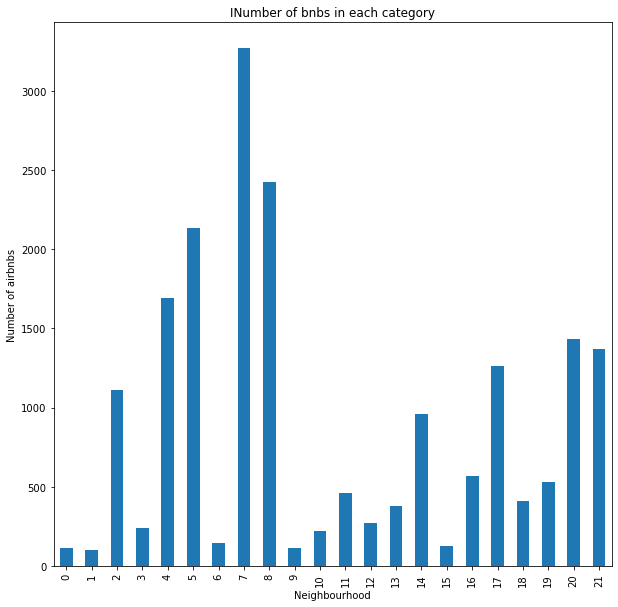

In [31]:
#avgbnb_merged=dfcat.sort_values('Venue')

s=avgbnb_merged['Number_of_Airbnbs']
s.plot(kind='bar', figsize=(10, 10))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Number of airbnbs') # add y-label to the plot
plt.title('INumber of bnbs in each category') # add title to the plot

plt.show()

In [32]:
# Opening JSON file 
f = open('neighbourhoods.geojson',) 
  
# returns JSON object as  
# a dictionary 
ams_geo = json.load(f)
ams_cpmap = folium.Map(location=[latitude, longitude], zoom_start=11)
ams_cpmap.choropleth(
    geo_data=ams_geo,
    data=avgbnb_merged,
    columns=['Neighbourhood','avg_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average AirBnB price per neighbourhood in Euros'
)

# display map
ams_cpmap

In [33]:
# Opening JSON file 
f = open('neighbourhoods.geojson',) 
  
# returns JSON object as  
# a dictionary 
ams_geo = json.load(f)
ams_cpmap = folium.Map(location=[latitude, longitude], zoom_start=11)
ams_cpmap.choropleth(
    geo_data=ams_geo,
    data=avgbnb_merged,
    columns=['Neighbourhood','Number_of_Airbnbs'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of AirBnBs'
)



# display map
ams_cpmap

In [34]:
ams_cpmap = folium.Map(location=[latitude, longitude], zoom_start=11)
ams_cpmap.choropleth(
    geo_data=ams_geo,
    data=avgbnb_merged,
    columns=['Neighbourhood','avg_number_of_reviews'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Number of reviews per AirBnB'
)
ams_cpmap

In [35]:
amsterdam_coffeshops=amsterdam_venues[amsterdam_venues['Venue Category']=='Coffee Shop']
amsterdam_coffeshops
amsterdam_parks=amsterdam_venues[amsterdam_venues['Venue Category']=='Bar']
amsterdam_parks

# create map of Amsterdam using latitude and longitude values
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, category in zip(amsterdam_parks['Venue Latitude'], amsterdam_parks['Venue Longitude'], amsterdam_parks['Venue Category']):
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
 
for lat, lng, category in zip(amsterdam_coffeshops['Venue Latitude'], amsterdam_coffeshops['Venue Longitude'], amsterdam_coffeshops['Venue Category']):
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

In [36]:
ams_cpmap = folium.Map(location=[latitude, longitude], zoom_start=11)
ams_cpmap.choropleth(
    geo_data=ams_geo,
    data=avgbnb_merged,
    columns=['Neighbourhood','avg_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average AirBnB price per neighbourhood in Euros'
)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amsterdam_merged['Latitude'], amsterdam_merged['Longitude'], amsterdam_merged['Neighbourhood'], amsterdam_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ams_cpmap)
    
# display map
ams_cpmap